# Toxic Comment Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv('Data.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
al=train[train.columns[2:]].sum(axis=1)

In [6]:
info=[]
y=train.shape[0]
info.append(['with no label',len(al[al==0]),(len(al[al==0])/y)*100])
for i in train.columns[2:]:
    x=len(train[train[i]==1][i])
    info.append([i,x,(x/y)*100])

In [7]:
pd.DataFrame(info,columns=['Comment type','Count','%'])

,Comment type,Count,%
0,with no label,143346,89.832112
1,toxic,15294,9.584448
2,severe_toxic,1595,0.999555
3,obscene,8449,5.294822
4,threat,478,0.299553
5,insult,7877,4.936361
6,identity_hate,1405,0.880486


**This is a problem of multi-label classification many times people confuse in multi-label and multi-class.**
* The main difference between the two is lying in the concept of being mutually exclusive
* **Multi-class classifications** problems are those where each sample belongs to atmost one class only. Eg: In a coin toss the result can either be a heads or tails
* Whereas in case of **Multi-label classifications** each sample may belong to more than one class. Eg: A news article may belong to sports as well as politics.

In [8]:
multi=al.value_counts()[1:]
multi

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64

Text(0.5, 1.0, 'Indivisual comments that belong to multiple classes')

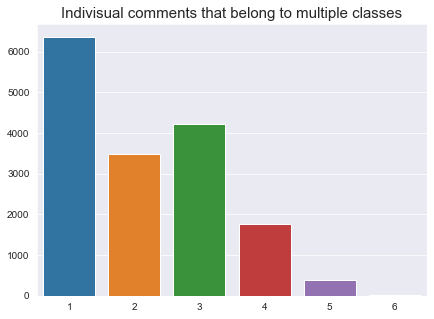

In [9]:
plt.figure(figsize=(7,5))
sns.barplot(x=multi.index,y=multi)
plt.title('Indivisual comments that belong to multiple classes',fontsize=15)

In [10]:
df=train.copy()

**Calculating word count**

In [11]:
import textstat

In [12]:
df['word_count']=[textstat.lexicon_count(i,removepunct=True) for i in df['comment_text'].values]

In [13]:
for i in train.columns[2:]:
    print(df[['word_count',i]].groupby(i).mean())
    print('-----------------------------------')

       word_count
toxic            
0       67.907095
1       50.708317
-----------------------------------
              word_count
severe_toxic            
0              66.168317
1              75.209404
-----------------------------------
         word_count
obscene            
0         67.217956
1         49.100840
-----------------------------------
        word_count
threat            
0        66.292722
1        54.930962
-----------------------------------
        word_count
insult            
0        67.214412
1        47.853498
-----------------------------------
               word_count
identity_hate            
0               66.388699
1               51.622776
-----------------------------------


It can be observed that except for severe_toxic all the comment belonging to non clean category have a lower average word count

**Symbols like "!*@#$*&" are also used when abusive words are used**

In [14]:
from nltk.tokenize import regexp_tokenize

In [15]:
df['sp_char']=[len(regexp_tokenize(i,"[!@#$&]")) for i in df['comment_text'].values]

In [16]:
for i in train.columns[2:]:
    print(df[['sp_char',i]].groupby(i).mean())
    print('-----------------------------------')

        sp_char
toxic          
0      0.447112
1      3.705113
-----------------------------------
                sp_char
severe_toxic           
0              0.600743
1             16.470846
-----------------------------------
          sp_char
obscene          
0        0.611248
1        3.408806
-----------------------------------
          sp_char
threat           
0        0.711012
1       16.855649
-----------------------------------
         sp_char
insult          
0       0.601164
1       3.806144
-----------------------------------
                sp_char
identity_hate          
0              0.744066
1              2.482562
-----------------------------------


It is clearly evident that there is a high probability that a comment with symbols like this !@#$& will be a non clean comment

**Calculating Unique word count**
* There are chances that abusive comments use words repeatively

In [17]:
from nltk.tokenize import word_tokenize

In [18]:
df['unique_w_count']=[len(set(word_tokenize(i))) for i in df['comment_text'].values]

In [19]:
for i in train.columns[2:]:
    print(df[['unique_w_count',i]].groupby(i).mean())
    print('-----------------------------------')

       unique_w_count
toxic                
0           51.774392
1           33.802798
-----------------------------------
              unique_w_count
severe_toxic                
0                  50.322878
1                  23.214420
-----------------------------------
         unique_w_count
obscene                
0             51.105716
1             31.203219
-----------------------------------
        unique_w_count
threat                
0            50.113852
1            29.437238
-----------------------------------
        unique_w_count
insult                
0            51.067603
1            30.491939
-----------------------------------
               unique_w_count
identity_hate                
0                   50.223367
1                   30.750890
-----------------------------------


It is also clear that non clean comments use less unique words

# Lets explore the comments

In [20]:
train.comment_text[5]

'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [21]:
train.comment_text[1151]

'Back atcha\n\nAnd thanks to you too!  Cheers,  (talk)'

In [22]:
train.comment_text[8523]

'"\n\n Edit request for video games section \n\nThe section ICarly#Video games could use an update to the second paragraph to the effect that there has been a second game released by this publisher.  Something along the lines of \n\n""Activision released a sequel, iCarly 2: iJoin the Click, for the same platforms in November 2010.""\n\nor words to that effect should cover it.  If you need sources:\n\n IGN\n Gamers Hell\n\nThanks.  88.104.32.76  "'

# Text Cleaning
Most of the comments have **\n, punctuations, numbers, extra whitespaces, contractions and lots of stopwords**  lets remove that first 

In [23]:
import re
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

Function for removing **\n**

In [24]:
def slash_n(text):
    #removing \n
    text=re.sub('\n',' ',text)
    #converting whole string into lowercase
    text=text.lower()
    return text

In [25]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

<font size ='4'>**Dealing with contractions**</font>
* A contraction is an abbreviation for a sequence of words
* eg: "you'll" is a contraction of "you will"

In [26]:
def contraction(text):
    """
    This function will return the text in  an expanded form which is in common English. It also helps in generalising the tokens
    """
    tokens=word_tokenize(text)
    tok=[]
    for i in tokens:
        if i in CONTRACTION_MAP.keys():
            tok.append(CONTRACTION_MAP[i])
        else:
            tok.append(i)
    return ' '.join(tok)

**Created a combined list of Stopwords taken form nltk corpus and spacy library**

In [27]:
#using stopwords from both libraries
nltk_sw=stopwords.words('english')
spacy_sw=list(STOP_WORDS)
#removing duplicates by converting list into set
stopword=list(set(nltk_sw+spacy_sw))

**Removing** Punctuations, Stopwords, Whitespaces and Non Alphabatics.

In [28]:
nlp=spacy.load('en_core_web_md')

In [29]:
def sw(text):
    text=textstat.remove_punctuation(text) #removing punctuations
    tokens=text.split()
    tok=[]
    for i in tokens:
        if i not in stopword:              #removing stopwords
            i=i.strip()                    #removing all leading and trailing whitespaces as they will create bais in next step
            if i.isalpha():                #removing non alphabatics
                tok.append(i)
    return ' '.join(tok)

<font size ='4'>**Performing Stemming**</font>
* We could also have used lemmatization but SnowballStemmer generalises words more efficiently by transforming words with roughly the same semantics to one standard form.
* Their are 2 methods for lemmatization using spacy's .lemma_ or WordNetLemmatizer
* For this problem we are using SnowballStemmer because its more advanced and takes less computational time as compared to PorterStemmer 

In [30]:
#Using SnowballStemmer
def stemming(text):
    stem=SnowballStemmer('english')
    doc=word_tokenize(text)
    tok=[stem.stem(i) for i in doc]
    return ' '.join(tok)

In [31]:
train['comment_text']=train['comment_text'].apply(slash_n)

In [32]:
train['comment_text']=train['comment_text'].apply(contraction)

In [33]:
train['comment_text']=train['comment_text'].apply(sw)

In [34]:
train['comment_text']=train['comment_text'].apply(stemming)

# Generating Wordclouds for all categories

In [35]:
from wordcloud import WordCloud

In [36]:
def wordcloud_gen(i):
    texts=train[train[i]==1]['comment_text'].values
    wordcloud = WordCloud(background_color='black',width=700,height=500,colormap='viridis').generate(" ".join(texts))
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud)
    plt.title(str(i).upper(),fontsize=15)
    plt.grid(False)
    plt.axis(False)

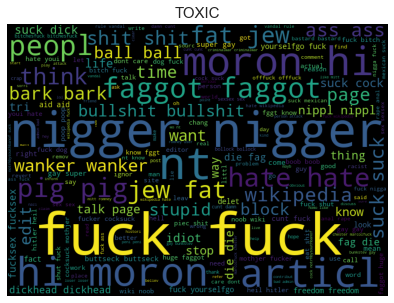

In [37]:
wordcloud_gen('toxic')

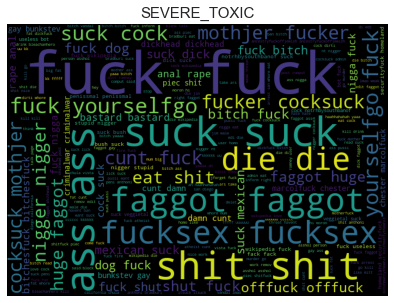

In [38]:
wordcloud_gen('severe_toxic')

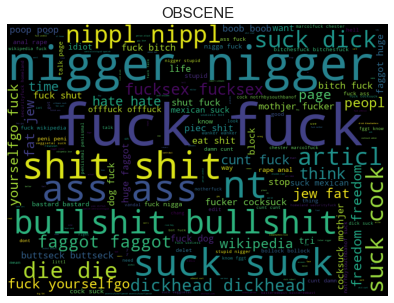

In [39]:
wordcloud_gen('obscene')

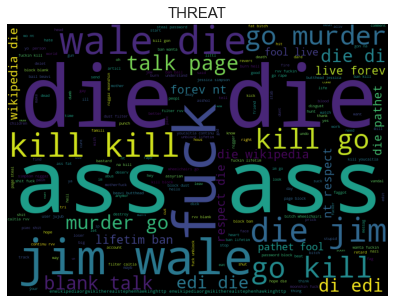

In [40]:
wordcloud_gen('threat')

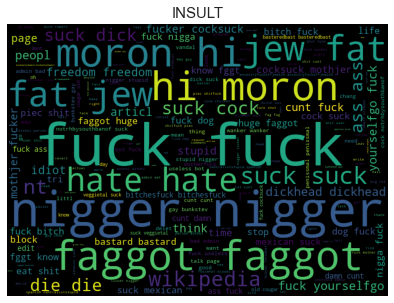

In [41]:
wordcloud_gen('insult')

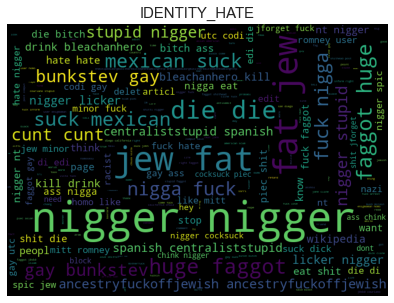

In [42]:
wordcloud_gen('identity_hate')

These wordclouds also indicate that an indivisual comment may belongs to multiple classes as there are many

(-0.5, 699.5, 499.5, -0.5)

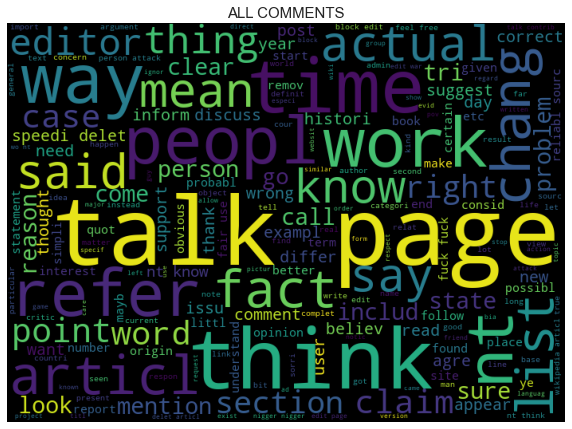

In [43]:
texts=train['comment_text'].values
wordcloud = WordCloud(background_color='black',width=700,height=500,colormap='viridis').generate(" ".join(texts))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.title('ALL COMMENTS',fontsize=15)
plt.grid(False)
plt.axis(False)

**Lets Split the data to perform further operations**

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
training, testing=train_test_split(train, random_state=42, test_size=0.30, shuffle=True)

In [46]:
training.shape,testing.shape

((111699, 8), (47872, 8))

Now We'll convert these strings into vectors using **TfidfVectorizer**
* We need to find the most frequently occurring terms i.e. words with high term frequency or **tf**
* We also want a measure of how unique a word is i.e. how infrequently the word occurs across all documents i.e. inverse document frequency or **idf**
**Hence Tf-idf**

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

Choosing an optimum value for max_features is very necessary especially when you are dealing with such a big dataset.
* If the value is set too high the memory of your system will *fail to handle the amount of data*
* And if the value is set too low then you'd be *under-utilizing your data*

In [48]:
unique_words=len(set((' '.join(training['comment_text'].values)).split()))
print('Total unique words in the training corpus is ',unique_words,', this means the vectorizer can create at max ',unique_words," vectors & definitely while creating so many vectors we'll run out of memory")

Total unique words in the training corpus is  128458 , this means the vectorizer can create at max  128458  vectors & definitely while creating so many vectors we'll run out of memory


In [49]:
#I have used 2500 as max_features but a higher value could also be tried as per system configration
tfidf=TfidfVectorizer(strip_accents='unicode',max_features=2500,min_df=2,max_df=0.9)

Fitting TfidfVectorizer only on the training set.

In [50]:
tfidf.fit(training['comment_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=2500,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [51]:
x_train=tfidf.transform(training['comment_text'])
y_train=training.drop(labels = ['id','comment_text'], axis=1)

As i have used 2500 as max_features there are only 2500 columns in our dataset

In [52]:
x_train.shape

(111699, 2500)

In [53]:
x_test=tfidf.transform(testing['comment_text'])
y_test=testing.drop(labels = ['id','comment_text'], axis=1)

Importing necessary Models

In [54]:
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score

# OneVsRest
* Here the multi-label problem is decomposed into multiple independent binary classification problems
* Here each accuracy_score depicts the accuracy of model in predicting whether the comment is say toxic or not.

In [55]:
pred={}
log=LogisticRegression()
for i in y_train.columns:
    log.fit(x_train, y_train[i])
    print('For',i,'accuracy_score',round(accuracy_score(y_test[i],log.predict(x_test))*100,1),'%')
    print('-------------------------------------------------')
    pred[i]=log.predict_proba(x_test)[:,1]

For toxic accuracy_score 95.7 %
-------------------------------------------------
For severe_toxic accuracy_score 99.0 %
-------------------------------------------------
For obscene accuracy_score 97.8 %
-------------------------------------------------
For threat accuracy_score 99.7 %
-------------------------------------------------
For insult accuracy_score 97.1 %
-------------------------------------------------
For identity_hate accuracy_score 99.2 %
-------------------------------------------------


In [56]:
print('roc_auc_score using OneVSRest is ',roc_auc_score(y_test,pd.DataFrame(pred)))

roc_auc_score using OneVSRest is  0.9727732689721947


# BinaryRelevance
* This one is an ensemble of single-class (Yes/No) binary classifier
* If there are n number of different labels it will create n datasets and train for each label and will result the union of all predicted labels.
* Here the correlation b/w the labels is not taken into account

In [57]:
classifier = BinaryRelevance(LogisticRegression())

In [58]:
classifier.fit(x_train, y_train)
print('Accuracy_score using BinaryRelevance is ',round(accuracy_score(y_test,classifier.predict(x_test))*100,1),'%')
print('-------------------------------------------------')
print('roc_auc_score using BinaryRelevance is ',roc_auc_score(y_test,classifier.predict_proba(x_test).toarray()))

Accuracy_score using BinaryRelevance is  92.0 %
-------------------------------------------------
roc_auc_score using BinaryRelevance is  0.9727732696916541


# Label Powerset
* Label Powerset creates a unique class for every possible label combination that is present in the training set, this way it makes use of label correlation
* Only problem with this method is as the no of classes increases its computational complexity also increases.

In [59]:
log_classifier=LabelPowerset(LogisticRegression())

In [60]:
log_classifier.fit(x_train, y_train)
print('Accuracy_score using LabelPowerset is ',round(accuracy_score(y_test,log_classifier.predict(x_test))*100,1),'%')
print('-------------------------------------------------')
print('roc_auc_score using LabelPowerset is ',roc_auc_score(y_test,log_classifier.predict_proba(x_test).toarray()))

Accuracy_score using LabelPowerset is  91.8 %
-------------------------------------------------
roc_auc_score using LabelPowerset is  0.9731050140301366


# ClassifierChain
* This method uses a chain of binary classifiers
* Each new Classifier uses the predictions of all previous classifiers
* This was the correlation b/w labels is taken into account

In [61]:
chain=ClassifierChain(LogisticRegression())

In [62]:
chain.fit(x_train, y_train)
print('Accuracy_score using ClassifierChain is ',round(accuracy_score(y_test,chain.predict(x_test))*100,1),'%')
print('-------------------------------------------------')
print('roc_auc_score using ClassifierChain is ',roc_auc_score(y_test,chain.predict_proba(x_test).toarray()))

Accuracy_score using ClassifierChain is  92.1 %
-------------------------------------------------
roc_auc_score using ClassifierChain is  0.9633564816788193


Reference for Model Building:
https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/